# Project: Monocular Depth Estimation

<img src='https://i.imgur.com/I2rSgxd.png' width=200> <img src='https://i.imgur.com/1oP2EIg.png' width=200>

## Introduction

- In this project you are tasked to create a model that **estimates depth from a single input image**. The input is an RGB image and the output is a single channel dense depth map where each pixel is the estimated distance from the 'camera sensor' to an object in the scene in real world units (e.g. in meters). Depth from a single image is a fundemental vision task with many useful applications including scene understanding and reconstruction. 

- You are to develop a convolutional neural network (CNN) that formulates the problem as a regression of the depth map from a single RGB image. You can find many papers and code related to this problem [here](https://paperswithcode.com/task/monocular-depth-estimation). 

- In the following, we provide all the source code needed for loading and evaluating your model. 

- Your task in this project is to modify the script in order to:
    - Define a [UNet](https://arxiv.org/abs/1505.04597) model that takes an RGB image and outputs a single channel depth map. **[50 points]**
    - Define an approprate loss function. **[25 points]**
    - Tune the model to achieve an RMSE of **0.035** or less on the given validation set. **[25 points]**


<hr/>

**Note**: Make sure that your Collab notebook is a GPU instance. Also, the first time you run the training, the instance might crash for exceeding the allocated memory. This is expected behaviour, especially with large batch sizes. Collab will suggest restarting the session and providing instances with larger memory sizes.

**Note**: This project is more open-ended than the previous projects. Multiple solutions can be considered _correct_. As there already exist implementations of various deep networks for this task on the interwebs, **plagiarism will NOT be tolerated**. Your code will be judged for similarity against code available online and other students' code. You are expected to justify every design decision when your project is being evaluated.

**Note**: The networks you will design/implement will be much larger than what you have previously designed. Please bring hardware concerns to the attention of the [TA](mailto:wamiq.para@kaust.edu.sa). You will need to begin early to test out new ideas/hyperparameters and training will take much longer. Best of luck!

<hr/>

## Downloading Data
Run the following cell to download the dataset and extract the zip archive.

If you are not running a Linux/Mac machine. Please download the following zip file manually and extract it in the same directory as the notebook.

In [ ]:
# ! wget -nc https://densedepth2019.s3.amazonaws.com/UnrealData256.zip
# ! unzip -nq UnrealData256.zip

## Hyperparameters

You are supposed to change the batch_size and learning_rate from their default value.

In [2]:
import os
import gc
import time
import datetime
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

epochs = 100 
batch_size = 128  ## Tesla-V100 32GB
learning_rate = 0.00003
workers = 40 # The number of parallel processes used to read data
gpu_id = [0] # only modify if you machine has more than one GPU card

In [3]:
# %cd Depth_Estimation/

## Data Loader (no tasks required)

In [4]:
if __name__ == '__main__':
    import torch.multiprocessing as mp
    from loaders import prep_loaders
    train_loader, valid_loader = prep_loaders('UnrealData256', batch_size=batch_size, workers=workers)

Dataset size (num. batches) 199 5


## Sanity check 

Populating the interactive namespace from numpy and matplotlib
torch.Size([128, 3, 256, 256]) torch.Size([128, 1, 128, 128])


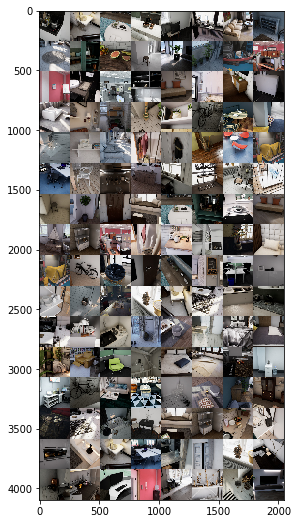

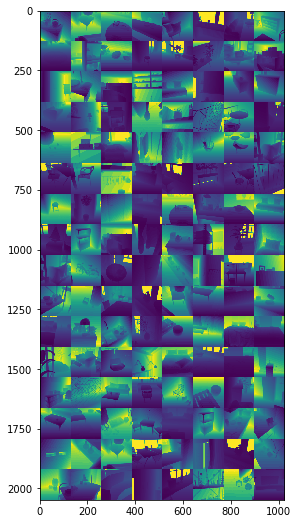

In [5]:
# Examine training data
%pylab inline
import torchvision
sample = iter(train_loader).next()
print(sample['image'].shape, sample['depth'].shape)
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(9,9)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])

## Model [50 points]

Define your model here. The current model is going to perform very poorly on the task. 
But it will be fast. You are welcome to run it.

In [6]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch

In [7]:
def get_features(image, model, layers):
    # Run an image forward through a model and get the features for a set of layers.
        
    features = []
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features.append(x)
            
    return features

In [8]:
for name, layer in torch.hub.load('pytorch/vision', 'resnext50_32x4d', pretrained=True)._modules.items():
    print(name)

Using cache found in /home/qus/.cache/torch/hub/pytorch_vision_master


conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [9]:
## 
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.encoder = torch.hub.load('pytorch/vision', 'resnext50_32x4d', pretrained=True)
        self.encoder._modules['avgpool'] = nn.Sequential()
        self.encoder._modules['fc'] = nn.Sequential()

        ##
        self.decoder_layer1 = nn.Sequential(
            nn.Conv2d(3072, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_layer2 = nn.Sequential(
            nn.Conv2d(1024, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.decoder_layer3 = nn.Sequential(
            nn.Conv2d(512, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.decoder_layer4 = nn.Sequential(
            nn.Conv2d(128, 1, 3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1, 1, 3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )
    


    def forward(self, input_image):
 
        ## Need the layers for the representations of an image
        # definition of all the layers needed from resnext50_32x4d
        layers_encoder = ['bn1','layer1','layer2', 'layer3', 'layer4']
        features = get_features(input_image, self.encoder, layers_encoder)
        
        #print(input_image.shape)
        x_up_4 = F.interpolate(features[4], scale_factor=2, mode="nearest")
        x = torch.cat([features[3], x_up_4], dim=1)
        #print(x.shape)
        x = self.decoder_layer1(x)

        x_up_3 = F.interpolate(x, scale_factor=2, mode="nearest")
        x = torch.cat([features[2], x_up_3], dim=1)
        # print(x.shape)
        x = self.decoder_layer2(x)
        
        x_up_2 = F.interpolate(x, scale_factor=2, mode="nearest")
        x = torch.cat([features[1], x_up_2], dim=1)
        # print(x.shape)
        x = self.decoder_layer3(x)
        
        x_up_1 = F.interpolate(x, scale_factor=2, mode="nearest")
        x = torch.cat([features[0], x_up_1], dim=1)
        # print(x.shape)
        x = self.decoder_layer4(x)
        
        # x = torch.sigmoid(x)
        
        return x
        
        


In [10]:
def create_model_gpu():
    model = mymodel()
    model = model.cuda()
    # model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
    return model

model = create_model_gpu()
print('Ready to train.')

Using cache found in /home/qus/.cache/torch/hub/pytorch_vision_master


Ready to train.


In [11]:
#import torchvision.models as models
#from collections import OrderedDict
from torchsummary import summary

summary(model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5          [-1, 128, 64, 64]           8,192
       BatchNorm2d-6          [-1, 128, 64, 64]             256
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]           4,608
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          32,768
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [12]:
# import torch.nn as nn
# import torch.nn.functional as F

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.A = nn.Conv2d(3, 1, kernel_size=3, padding=1, stride=2)

#     def forward(self, x):
#         return self.A(x)
    
# def create_model_gpu():
#     model = Model()
#     model = model.cuda()
#     model = nn.DataParallel(model, device_ids=[g for g in gpu_id])
#     return model

# model = create_model_gpu()
# print('Ready to train.')

# #model.load_state_dict(torch.load('trained_model.pkl'))

## Loss Function [25 points]

Define a loss function that is suitable for the dense regression task.
Why will the current loss not work? Submit the answer in the notebook.

In [13]:
import torch
from math import exp
import torch.nn.functional as F


def loss_fn(pred_y, y):
    return torch.nn.functional.mse_loss(pred_y, y)

## Training + Evaluation [25 points]

Tune the hyperparameters and the architecture to achieve the target RMSE

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
run_id = 'model_gpu{}_n{}_bs{}_lr{}'.format(gpu_id, epochs, batch_size, learning_rate); print('\n\nTraining', run_id)
save_path = run_id + '.pkl'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

class RMSE(object):
    def __init__(self):
        self.sq_errors = []
        self.num_pix = 0
        
    def get(self):
        return np.sqrt(
                    np.sum(np.array(self.sq_errors))/self.num_pix
                )
    
    def add_batch(self, pred, target):
        sqe = (pred-target)**2
        self.sq_errors.append(np.sum(sqe))
        self.num_pix += target.size
        
    def reset(self):
        self.sq_errors = []
        self.num_pix = 0


# Used to keep track of statistics
class AverageMeter(object):
    def __init__(self):
        self.val = 0; self.avg = 0; self.sum = 0; self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

REPORTS_PER_EPOCH = 10
ITER_PER_EPOCH = len(train_loader)
ITER_PER_REPORT = ITER_PER_EPOCH//REPORTS_PER_EPOCH

metrics = RMSE()

for epoch in range(epochs):
    model.train()
    
    # Progress reporting
    batch_time = AverageMeter()
    losses = AverageMeter()
    N = len(train_loader)
    end = time.time()

    for i, (sample) in enumerate(train_loader):

        # Load a batch and send it to GPU
        x = sample['image'].float().cuda()
        y = sample['depth'].float().cuda()

        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(x)

        # Compute and print loss.
        loss = loss_fn(y_pred, y)
        
        # Record loss
        losses.update(loss.data.item(), x.size(0))

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model).
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
        
        # Measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        eta = str(datetime.timedelta(seconds=int(batch_time.val*(N - i))))

        # Log training progress
        if i % ITER_PER_REPORT == 0:
            print('\nEpoch: [{0}][{1}/{2}]\t' 'Time {batch_time.val:.3f} ({batch_time.sum:.3f})\t' 'ETA {eta}\t'
             'Training Loss {loss.val:.4f} ({loss.avg:.4f})'.format(epoch, i, N, batch_time=batch_time, loss=losses, eta=eta))
        elif True: #i % (ITER_PER_REPORT//50) == 0:
            print('.', end='')
            
        #break # useful for quick debugging        
    torch.cuda.empty_cache(); del x, y; gc.collect()
    
    # Validation after each epoch
    model.eval()
    metrics.reset()
    for i, (sample) in enumerate(valid_loader):
        x, y = sample['image'].float().cuda(), sample['depth'].float().numpy()
        with torch.no_grad():
            y_pred = model(x).detach().cpu().numpy()

        metrics.add_batch(y_pred, y)
        print('_', end='')
    print('\nValidation RMSE {avg_rmse}'.format(avg_rmse=metrics.get()))
    

# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))



Training model_gpu[0]_n100_bs128_lr3e-05

Epoch: [0][0/199]	Time 6.305 (6.305)	ETA 0:20:54	Training Loss 0.2340 (0.2340)
..................
Epoch: [0][19/199]	Time 4.748 (93.503)	ETA 0:14:14	Training Loss 0.0252 (0.0668)
..................
Epoch: [0][38/199]	Time 5.186 (190.025)	ETA 0:13:54	Training Loss 0.0281 (0.0482)
..................
Epoch: [0][57/199]	Time 4.906 (286.271)	ETA 0:11:36	Training Loss 0.0294 (0.0413)
..................
Epoch: [0][76/199]	Time 5.064 (381.811)	ETA 0:10:22	Training Loss 0.0219 (0.0378)
..................
Epoch: [0][95/199]	Time 5.057 (478.885)	ETA 0:08:45	Training Loss 0.0238 (0.0354)
..................
Epoch: [0][114/199]	Time 5.119 (576.355)	ETA 0:07:15	Training Loss 0.0266 (0.0338)
..................
Epoch: [0][133/199]	Time 5.028 (673.086)	ETA 0:05:31	Training Loss 0.0242 (0.0322)
..................
Epoch: [0][152/199]	Time 5.013 (767.536)	ETA 0:03:55	Training Loss 0.0222 (0.0311)
..................
Epoch: [0][171/199]	Time 5.077 (864.818)	ETA 0:0

In [ ]:
# Save model
torch.save(model.state_dict(), save_path)
print('\nTraining done. Model saved ({}).'.format(save_path))

## Visual Test of the Trained Model (no tasks required)

In [ ]:
# Load model from disk
#model = create_model_gpu()
#model.load_state_dict(torch.load('trained_model.pkl'))
#model.eval() # set to evaluation mode

# Visualize validation sample
sample = iter(valid_loader).next()
x = sample['image'].float().cuda()
y_pred, y = model(x), sample['depth']

figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['image'], padding=0).permute((1, 2, 0)))
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(sample['depth'], padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])
figure(figsize=(20,20)); imshow(torchvision.utils.make_grid(y_pred.detach().cpu(), padding=0, normalize=True, scale_each=True).permute((1, 2, 0))[:,:,0])